In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

import proprocess_odeint

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)

path_ = os.path.abspath(os.path.join('..', '00_models'))

if path_ not in sys.path:
    sys.path.append(path_)

import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

To do: @jit/partial decorators missing? what does regularizer do? interpolation can be done a single time before training & function saved


In [220]:
importlib.reload(proprocess_odeint)
DataPreprocessor = proprocess_odeint.DataPreprocessor

file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

data_loader = DataPreprocessor(file_path, start_date = '2010-01-03', number_of_points = 400, tau = 1, m = 1, 
                               feature_encoding = encoding, split = 200, smooth = False, var_weekend = False)
data_subsample = data_loader.load_data()
# df_train, df_test = data_loader.preprocess_data(data_subsample)
d = data_loader.preprocess_data(data_subsample)

df_train, df_test = d[0], d[1]

Start Data: 2010-01-03 00:00:00
days_offset: 1
Offset: 2010-01-02 00:00:00


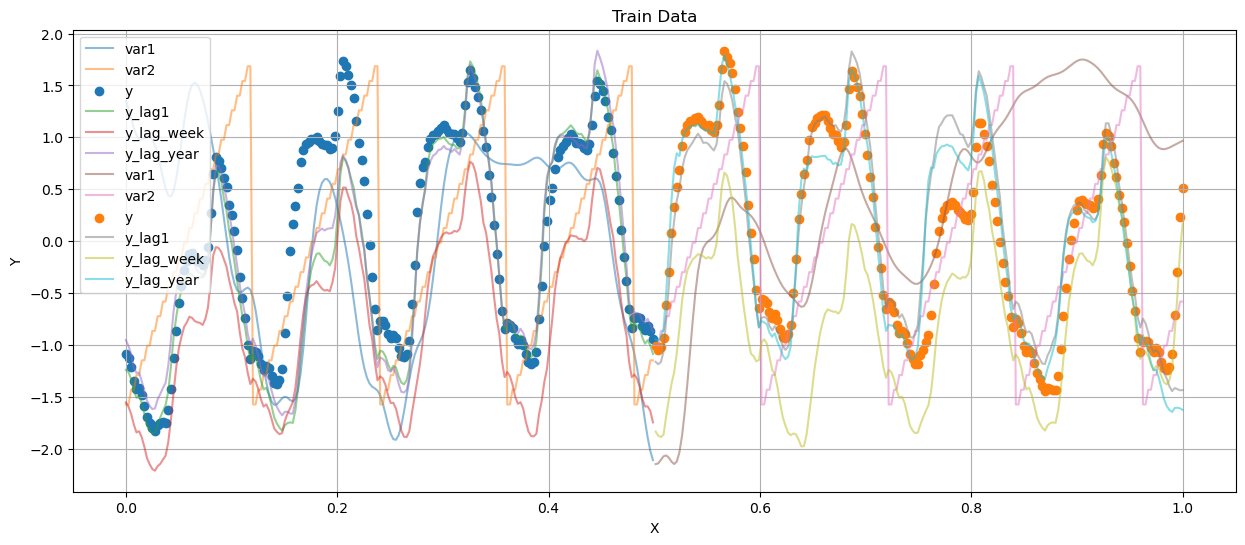

In [221]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        else:
            #continue
            plt.plot(df_train['t'], df_train[col], label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_test['t'], df_test[col], label=col, alpha=1)
            continue
        else:
            #continue
            plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [234]:
ys = jnp.atleast_2d(jnp.array(df_train['y'])).T
ts = jnp.array(df_train['t'])
Xs = jnp.array(df_train.drop(columns=['y', 't']))
extra_args = (Xs, ts)
y0 = jnp.array(ys[0])

In [235]:
def ensure_float32(arrays):
    return [x.astype(jnp.float32) if x.dtype != jnp.float32 else x for x in arrays]

ys = ensure_float32([ys])[0]
ts = ensure_float32([ts])[0]
Xs = ensure_float32([Xs])[0]
extra_args = (Xs, ts)

In [236]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [6, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

state = node_model.train(state, ts 
                         , ys, y0
                         , num_epochs = 10000
                         , extra_args=extra_args
                         )

To do: @jit/partial decorators missing? what does regularizer do? interpolation can be done a single time before training & function saved
Epoch 100, Loss: 0.7699060440063477
Epoch 200, Loss: 0.7152652740478516
Epoch 300, Loss: 0.6407326459884644
Epoch 400, Loss: 0.6023419499397278
Epoch 500, Loss: 0.5791062116622925
Epoch 600, Loss: 0.5802384614944458
Epoch 700, Loss: 0.571527898311615
Epoch 800, Loss: 0.5698031783103943
Epoch 900, Loss: 0.563824474811554
Epoch 1000, Loss: 0.5618699193000793
Epoch 1100, Loss: 0.560869574546814
Epoch 1200, Loss: 0.5572003722190857
Epoch 1300, Loss: 0.5554669499397278
Epoch 1400, Loss: 0.546125054359436
Epoch 1500, Loss: 0.5357732772827148
Epoch 1600, Loss: 0.523654580116272
Epoch 1700, Loss: 0.5159823894500732
Epoch 1800, Loss: 0.5045931339263916
Epoch 1900, Loss: 0.49233105778694153
Epoch 2000, Loss: 0.4805903732776642
Epoch 2100, Loss: 0.47391897439956665
Epoch 2200, Loss: 0.4647248089313507
Epoch 2300, Loss: 0.45476624369621277
Epoch 2400, Loss: 0.4

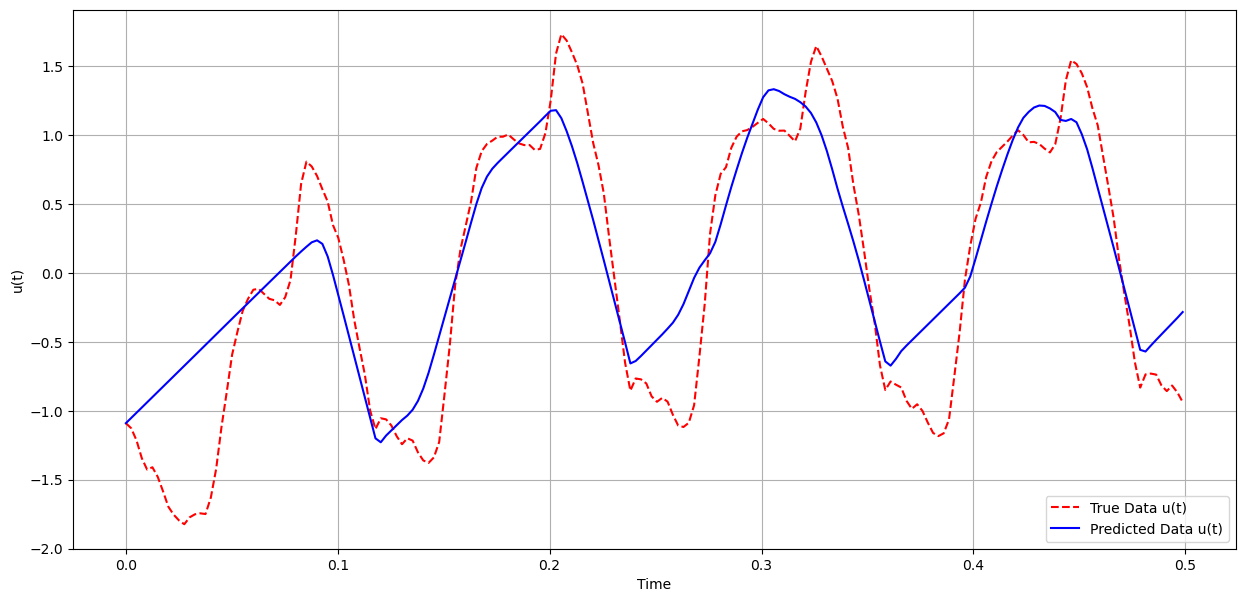

In [237]:
#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, np.squeeze(y_train_pred), 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()